## **A1 Data Curation**

This notebook loads the data about Wikipedia page traffic from two different <a id="https://www.mediawiki.org/wiki/Wikimedia_REST_API">Wikimedia REST API</a> endpoints into a single dataset, perform some simple data processing steps on the data, and then analyze that data.

### **Table of contents**###
1. <a id="test">Step1: Gather the Data via API calls and save it</a>
2. <a id="test">Step2: Processing the Data</a>
3. <a id="test">Step3: Analyze the Data</a>

In [1]:
import json
import requests
import os
from functools import reduce
from datetime import datetime

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

### Step1: Gather the Data via API calls and save it


Initialize endpoints:

In [2]:
ENDPOINT_PAGECOUNT = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
ENDPOINT_PAGEVIEWS = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Initialize api params:

In [3]:
PARAMS_PAGECOUNT = {"project" : "en.wikipedia.org",                 
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

PARAMS_PAGEVIEWS = {"project" : "en.wikipedia.org",                    
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }

HEADERS = {
    'User-Agent': 'https://github.com/arora-dhruv',
    'From': 'dharora@uw.edu'
}

Api call and utility functions:

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=HEADERS)
    response = call.json()
    
    return response

def write_json(data, path):
    data_json = json.dumps(data, indent=2)
    with open(path, "w") as f:
        f.write(data_json)

def read_json(path):
    with open(path) as f:
        data = json.load(f)
        
    return data

Collect and save monthly data from Page Count API for each access type:

In [5]:
def load_save_pagecount_data(access_type):
    access_params = {
        "access-site" : access_type
    }
    PARAMS_PAGECOUNT.update(access_params)    
    monthly_pagecount = api_call(ENDPOINT_PAGECOUNT, PARAMS_PAGECOUNT)
    
    output_filename = "{api_type}_{accesstype}_{start}-{end}.json".format(api_type="pagecount", \
                                                                      accesstype=access_type, \
                                                                      start=PARAMS_PAGECOUNT["start"],\
                                                                      end=PARAMS_PAGECOUNT["end"])
    output_path = os.path.join("json", output_filename)
    write_json(monthly_pagecount, output_path)
    
    return output_filename

In [6]:
pagecount_desktop_filename = load_save_pagecount_data('desktop-site')
pagecount_mobile_filename = load_save_pagecount_data('mobile-site')
print(pagecount_desktop_filename)
print(pagecount_mobile_filename)

pagecount_desktop-site_2007120100-2016080100.json
pagecount_mobile-site_2007120100-2016080100.json


Collect and save monthly data from Page View API for each access type:

In [7]:
def load_save_pageview_data(access_type):
    access_params = {
        "access" : access_type
    }
    PARAMS_PAGEVIEWS.update(access_params)    
    monthly_pageview = api_call(ENDPOINT_PAGEVIEWS, PARAMS_PAGEVIEWS)
    
    output_filename = "{api_type}_{accesstype}_{start}-{end}.json".format(api_type="pageview",\
                                                                      accesstype=access_type, \
                                                                      start=PARAMS_PAGEVIEWS["start"],\
                                                                      end=PARAMS_PAGEVIEWS["end"])
    output_path = os.path.join("json", output_filename)
    write_json(monthly_pageview, output_path)
    
    return output_filename

In [8]:
pageview_desktop_filename = load_save_pageview_data('desktop')
pageview_mobileapp_filename = load_save_pageview_data('mobile-app')
pageview_mobileweb_filename = load_save_pageview_data('mobile-web')
print(pageview_desktop_filename)
print(pageview_mobileapp_filename)
print(pageview_mobileweb_filename)

pageview_desktop_2015070100-2020090100.json
pageview_mobile-app_2015070100-2020090100.json
pageview_mobile-web_2015070100-2020090100.json


### Step2: Processing the data


Read the data saved in earlier step:

In [9]:
FOLDER_NAME = 'json/'
pagecount_desktop = read_json(FOLDER_NAME + pagecount_desktop_filename)
pagecount_mobile = read_json(FOLDER_NAME + pagecount_mobile_filename)
pageviews_desktop = read_json(FOLDER_NAME + pageview_desktop_filename)
pageview_mobileapp = read_json(FOLDER_NAME + pageview_mobileapp_filename)
pageviews_mobileweb = read_json(FOLDER_NAME + pageview_mobileweb_filename)

Convert json files into a dataframes, create all up metric counts:

In [10]:
PAGECOUNT_COLS = ['project', 'access-site', 'granularity', 'timestamp','count']
PAGEVIEWS_COLS = ['project', 'access', 'agent', 'granularity', 'timestamp', 'views']
DROP_COLS =['project', 'granularity', 'agent', 'access-site', 'access' ]

In [11]:
pagecount_desktop_df = pd.DataFrame(pagecount_desktop["items"],  columns=PAGECOUNT_COLS).drop(DROP_COLS, \
                                                                                              axis=1, errors='ignore')
pagecount_mobile_df = pd.DataFrame(pagecount_mobile["items"],  columns=PAGECOUNT_COLS).drop(DROP_COLS, \
                                                                                              axis=1, errors='ignore')
#combine page count access for all up view
pagecount_all_views_df = pd.concat([pagecount_desktop_df, pagecount_mobile_df], \
                                ignore_index=True).groupby(['timestamp']).sum().reset_index()
#rename count column
pagecount_all_views_df.rename(columns={'count': 'pagecount_all_views'}, inplace=True)
pagecount_desktop_df.rename(columns={'count': 'pagecount_desktop_views'}, inplace=True)
pagecount_mobile_df.rename(columns={'count': 'pagecount_mobile_views'}, inplace=True)


pageviews_desktop_df = pd.DataFrame(pageviews_desktop["items"],  columns=PAGEVIEWS_COLS).drop(DROP_COLS, \
                                                                                              axis=1, errors='ignore')
pageview_mobileapp_df = pd.DataFrame(pageview_mobileapp["items"],  columns=PAGEVIEWS_COLS).drop(DROP_COLS, \
                                                                                              axis=1, errors='ignore')
pageviews_mobileweb_df = pd.DataFrame(pageviews_mobileweb["items"],  columns=PAGEVIEWS_COLS).drop(DROP_COLS, \
                                                                                              axis=1, errors='ignore')

#combine page count access for all up view
pageviews_all_views_df = pd.concat([pageviews_desktop_df, pageview_mobileapp_df, pageviews_mobileweb_df], \
                                ignore_index=True).groupby(['timestamp']).sum().reset_index()
pageviews_all_views_df.rename(columns={'views': 'pageview_all_views'}, inplace=True)

#combine mobile app and mobile web from page views
pageviews_mobile_df = pd.concat([pageview_mobileapp_df, pageviews_mobileweb_df], \
                                ignore_index=True).groupby(['timestamp']).sum().reset_index()
pageviews_mobile_df.rename(columns={'views': 'pageview_mobile_views'}, inplace=True)

#rename count column
pageviews_desktop_df.rename(columns={'views': 'pageview_desktop_views'}, inplace=True)

Combine all dataframes:

In [12]:
combine_df= reduce(lambda x,y: pd.merge(x,y, on='timestamp', how='outer'),\
                   [pagecount_all_views_df, pagecount_desktop_df, pagecount_mobile_df,\
                    pageviews_all_views_df, pageviews_desktop_df, pageviews_mobile_df ]).fillna(0)

Create month and year columns:

In [13]:
combine_df['year'] = combine_df['timestamp'].str[:4].astype(int)
combine_df['month'] = combine_df['timestamp'].str[4:6]
combine_df.drop(['timestamp'], axis=1, inplace=True)

Output the dataset to csv:

In [14]:
output_csv_filename = "en-wikipedia_traffic_{from_date}-{to_date}.csv".format(from_date='200712', to_date='202008')
output_csv_filepath = os.path.join('csv', output_csv_filename)
combine_df.to_csv(output_csv_filepath, index=False)

### Step3: Analyze the data


In [15]:
combine_df['date'] = combine_df.apply(lambda r: datetime(int(r.year), int(r.month), 1), axis=1)
combine_df = combine_df.sort_values('date')

In [16]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

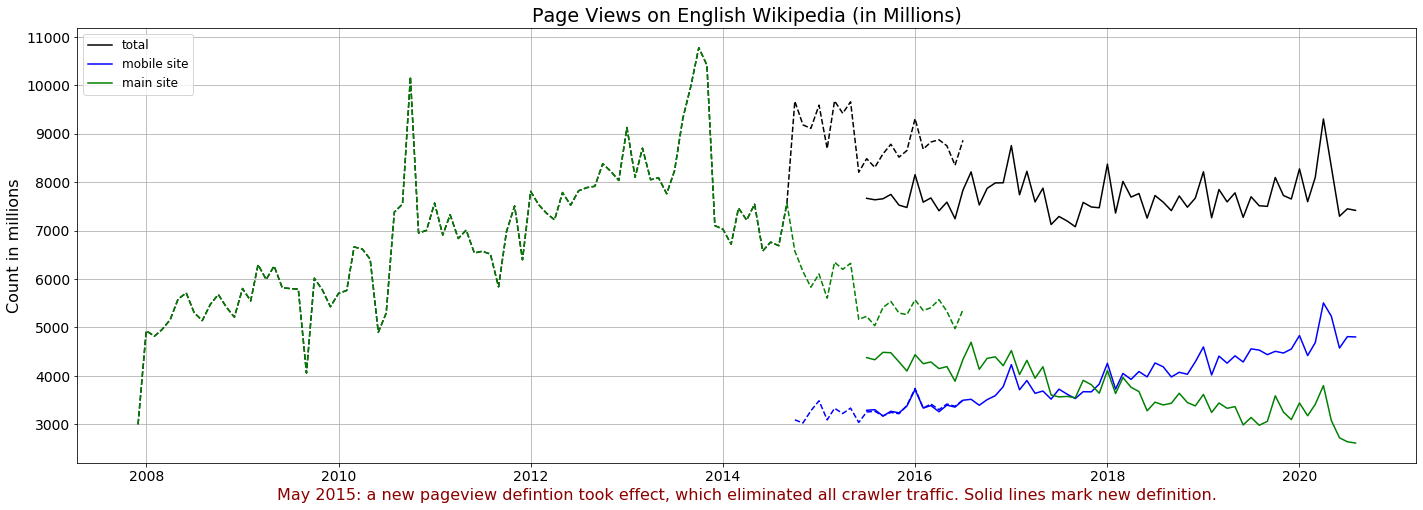

In [74]:
plt.figure(figsize=(24, 8))

plt.plot(combine_df.date, zero_to_nan(combine_df.pageview_all_views), color='black')
plt.plot(combine_df.date, zero_to_nan(combine_df.pageview_mobile_views), color='blue')
plt.plot(combine_df.date, zero_to_nan(combine_df.pageview_desktop_views), color='green')

plt.plot(combine_df.date, zero_to_nan(combine_df.pagecount_all_views), linestyle='dashed', color='black')
plt.plot(combine_df.date, zero_to_nan(combine_df.pagecount_mobile_views), linestyle='dashed', color='blue')
plt.plot(combine_df.date, zero_to_nan(combine_df.pagecount_desktop_views), linestyle='dashed', color='green')

plt.legend([ "total", "mobile site", "main site"], loc='upper left',fontsize=12)

plt.xlabel("May 2015: a new pageview defintion took effect, which eliminated all crawler traffic. Solid lines mark new definition.", color='darkred')
plt.ylabel("View Count")

import matplotlib.ticker as ticker
plt.ticklabel_format(axis="y", style="plain")

ax = plt.gca()
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Count in millions')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Page Views on English Wikipedia (in Millions)")
plt.grid()